In [1]:
import torch, math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.interpolate import griddata
from scipy.interpolate import LinearNDInterpolator
from pathlib import Path

import sys, os
sys.path.append(os.path.abspath("../../.."))
from Forward.mag3D import mag3D_8091
from Forward.utils import geomagnetic_field, calculateKernelMag

In [2]:
# 1) Modelo

model_npz = np.load("../../../models/modelA/mag_modelA.npz")

model = model_npz["Mag_model"] 
cell_centers = model_npz["cell_centers"]
dx = float(model_npz["dx"])
dy = float(model_npz["dy"])
dz = float(model_npz["dz"])

# 2) Receptores

receiver_location = np.load("receivers_modelA.npy")

In [3]:
# 3) Campo geomagnético 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype  = torch.float64
B0_vec, B0_unit = geomagnetic_field(I_deg=90, D_deg=0, amplitude_nT=50000, device=device, dtype=dtype)

# 4) Kernel

K, chi_active = calculateKernelMag(
    model=model,
    cell_centers=cell_centers,
    receiver_locations=receiver_location,
    dx=dx, dy=dy, dz=dz,
    B0_vec_nT=B0_vec,
    B0_unit=B0_unit,
    chunk_obs=64,
)

In [11]:
import numpy as np

# Convertir los tensores de PyTorch a arrays de Numpy
K_numpy = K.cpu().numpy()  # Asegúrate de que el tensor esté en la CPU
chi_active_numpy = chi_active.cpu().numpy()

# Guardar como archivo .npy
np.save('kernel_K.npy', K_numpy)  # Guardar K
np.save('kernel_chi_active.npy', chi_active_numpy)  # Guardar chi_active

In [4]:
# 5) Forward

dpred_nT = (K @ chi_active)

C:\Users\HDSP\AppData\Local\Temp\ipykernel_16956\2565540377.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  vmax = np.nanmax(np.abs(data))


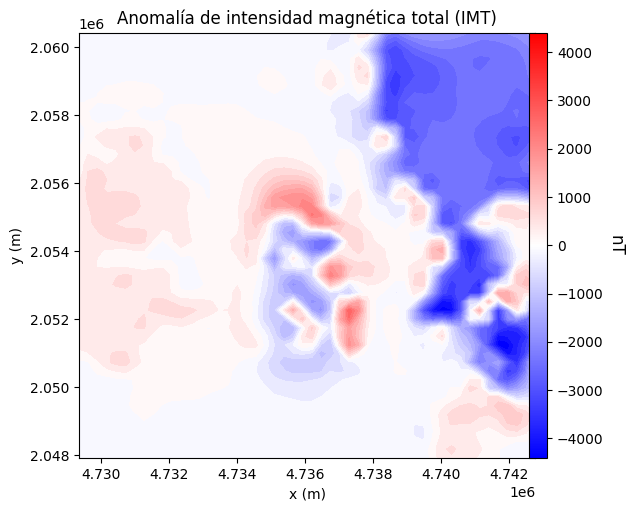

In [5]:
# 6) Plot

xy = receiver_location[:, :2]          # (nObs, 2)
data = dpred_nT              # (nObs,)

# ---------------------------
nx, ny = 50, 50 
xlin = np.linspace(xy[:,0].min(), xy[:,0].max(), nx)
ylin = np.linspace(xy[:,1].min(), xy[:,1].max(), ny)
X, Y = np.meshgrid(xlin, ylin)

Z = griddata(xy, data, (X, Y), method="cubic") 
# ---------------------------
vmax = np.nanmax(np.abs(data))

# ---------------------------
fig = plt.figure(figsize=(6, 5))

ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.85])
cs = ax1.contourf(
    X, Y, Z,
    levels=30,
    cmap="bwr",
    vmin=-vmax,
    vmax=vmax
)
ax1.set_title("Anomalía de intensidad magnética total (IMT)")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")
ax1.set_aspect("equal")

# ---------------------------
ax2 = fig.add_axes([0.87, 0.1, 0.03, 0.85])
norm = mpl.colors.Normalize(vmin=-vmax, vmax=vmax)
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, cmap=mpl.cm.bwr, orientation="vertical"
)
cbar.set_label("nT", rotation=270, labelpad=15, size=12)

plt.show()

C:\Users\HDSP\AppData\Local\Temp\ipykernel_16956\3685640617.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_model = mpl.cm.get_cmap("coolwarm").copy()
C:\Users\HDSP\AppData\Local\Temp\ipykernel_16956\3685640617.py:135: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0.06, 0.06, 0.94, 0.98])


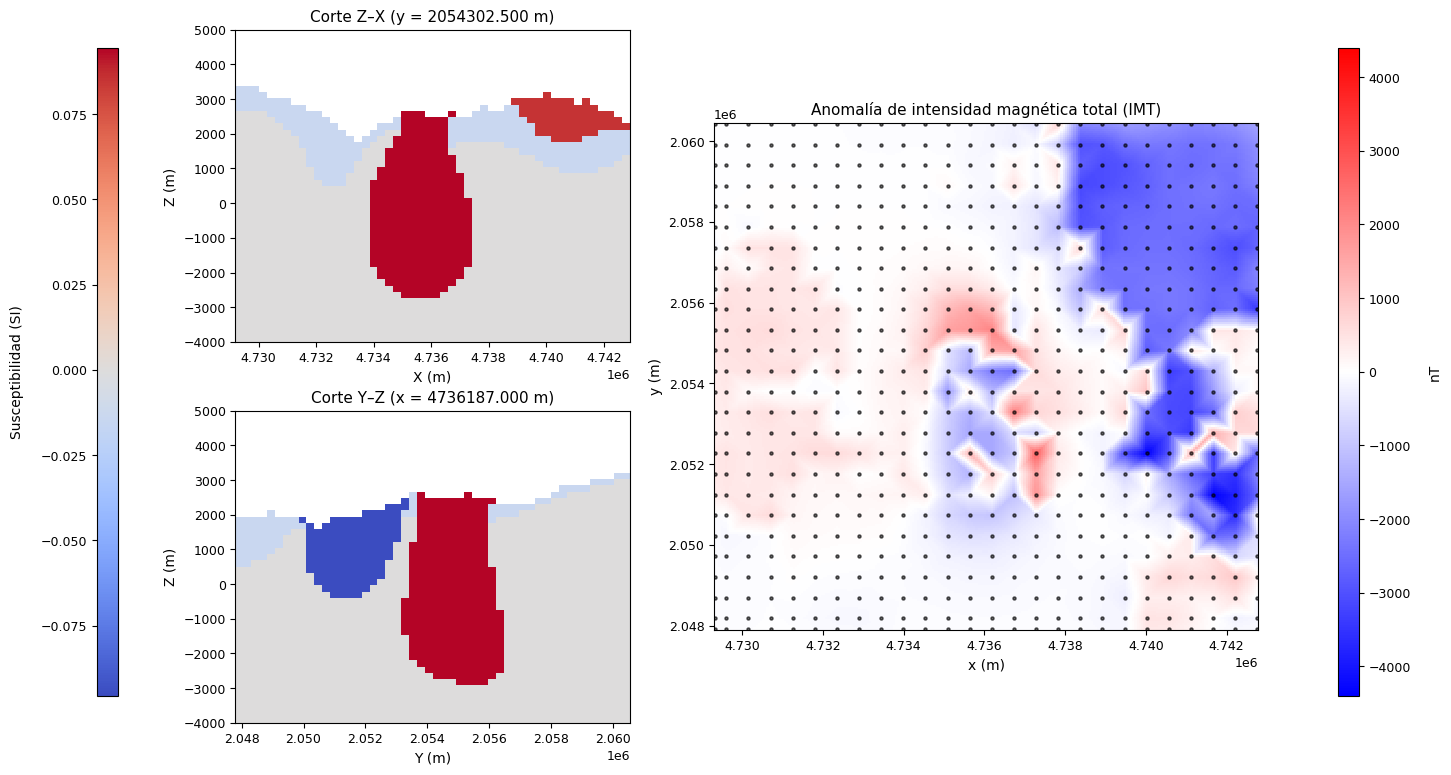

Guardado: C:\Users\HDSP\Documents\P8091-main-actualizado\P8091-main-actualizado\Examples\Modelling\Mag_modelA\Modelling_modelA.png


In [7]:
# 0) Estilo
mpl.rcParams.update({
    "font.size": 12, "axes.titlesize": 11, "axes.labelsize": 10,
    "xtick.labelsize": 9, "ytick.labelsize": 9,
})

# 1) Model a numpy (susceptibilidad)
if "torch" in str(type(model)):
    model_np = model.detach().cpu().numpy().ravel()
else:
    model_np = np.asarray(model).ravel()

cent = np.asarray(cell_centers, float)
x_c, y_c, z_c = cent[:, 0], cent[:, 1], cent[:, 2]

# 2) Reconstruir (nx,ny,nz) desde cell_centers
x_unique = np.unique(x_c); x_unique.sort()
y_unique = np.unique(y_c); y_unique.sort()
z_unique = np.unique(z_c); z_unique.sort()

nx, ny, nz = len(x_unique), len(y_unique), len(z_unique)

if nx * ny * nz != model_np.size:
    raise RuntimeError(f"No cuadra: {nx}*{ny}*{nz} != {model_np.size}  (revisa cell_centers vs model)")

# índices de grilla
ix = np.searchsorted(x_unique, x_c)
iy = np.searchsorted(y_unique, y_c)
iz = np.searchsorted(z_unique, z_c)

# 3) 3D con NaNs (como tú)
chi_3d = np.full((nz, ny, nx), np.nan, float)
chi_3d[iz, iy, ix] = model_np

# tu mismo transpose final
chi3d = chi_3d.T  # (nx, ny, nz)

# 4) cortes
iy_slice = ny // 2
ix_slice = nx // 2
y_slice_value = float(y_unique[iy_slice])
x_slice_value = float(x_unique[ix_slice])

chi_xz = chi3d[:, iy_slice, :]   # (nx, nz)
chi_yz = chi3d[ix_slice, :, :]   # (ny, nz)

# 5) edges para pcolormesh
dx_m = np.median(np.diff(x_unique)) if nx > 1 else 1.0
dy_m = np.median(np.diff(y_unique)) if ny > 1 else 1.0
dz_m = np.median(np.diff(z_unique)) if nz > 1 else 1.0

x_edges = np.r_[x_unique[0] - dx_m/2, x_unique + dx_m/2]
y_edges = np.r_[y_unique[0] - dy_m/2, y_unique + dy_m/2]
z_edges = np.r_[z_unique[0] - dz_m/2, z_unique + dz_m/2]

# 6) colormap modelo
chi_min = np.nanmin(model_np[np.isfinite(model_np)])
chi_max = np.nanmax(model_np[np.isfinite(model_np)])

cmap_model = mpl.cm.get_cmap("coolwarm").copy()
#cmap_model.set_bad(color="lightgrey")
norm_model = mpl.colors.Normalize(vmin=chi_min, vmax=chi_max)

C_xz = np.ma.masked_invalid(chi_xz.T)  # (nz,nx)
C_yz = np.ma.masked_invalid(chi_yz.T)  # (nz,ny)

# 7) datos (mapa)
locs = np.asarray(receiver_location, float)
if locs.shape[1] == 2:
    locs_xy = locs
else:
    locs_xy = locs[:, :2]

if "torch" in str(type(dpred_nT)):
    data = dpred_nT.detach().cpu().numpy().ravel()
else:
    data = np.asarray(dpred_nT, float).ravel()

valid = np.isfinite(data) & np.isfinite(locs_xy[:,0]) & np.isfinite(locs_xy[:,1])
locs_xy = locs_xy[valid]
data = data[valid]

# simétrico (estilo anomalía)
vmax = np.nanmax(np.abs(data))
vmin = -vmax

def plot_scattered_field(ax, locs_xy, values, vmin, vmax, title, cmap=cmap_model, nx=250, ny=250):
    x = locs_xy[:, 0]
    y = locs_xy[:, 1]

    xi = np.linspace(x.min(), x.max(), nx)
    yi = np.linspace(y.min(), y.max(), ny)
    XI, YI = np.meshgrid(xi, yi)

    interp = LinearNDInterpolator(np.c_[x, y], values)
    Zi = interp(XI, YI)

    im = ax.pcolormesh(XI, YI, Zi, shading="auto", cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.set_xlabel("x (m)")
    ax.set_ylabel("y (m)")
    ax.scatter(x, y, s=5, c="k", alpha=0.6)
    ax.set_aspect("equal", adjustable="box")
    return im

# 8) figura layout 2x2 (como tú)
fig = plt.figure(figsize=(13.2, 9))
gs = fig.add_gridspec(2, 2, width_ratios=[1.05, 1.45], wspace=0.18, hspace=0.22)

ax_zx  = fig.add_subplot(gs[0, 0])
ax_yz  = fig.add_subplot(gs[1, 0], sharey=ax_zx)
ax_map = fig.add_subplot(gs[:, 1])

pm_zx = ax_zx.pcolormesh(x_edges, z_edges, C_xz, cmap=cmap_model, norm=norm_model, shading="flat")
ax_zx.set_title(f"Corte Z–X (y = {y_slice_value:.3f} m)")
ax_zx.set_xlabel("X (m)")
ax_zx.set_ylabel("Z (m)")

pm_yz = ax_yz.pcolormesh(y_edges, z_edges, C_yz, cmap=cmap_model, norm=norm_model, shading="flat")
ax_yz.set_title(f"Corte Y–Z (x = {x_slice_value:.3f} m)")
ax_yz.set_xlabel("Y (m)")
ax_yz.set_ylabel("Z (m)")

mappable = plot_scattered_field(
    ax_map,
    locs_xy,
    data,
    vmin=vmin,
    vmax=vmax,
    title="Anomalía de intensidad magnética total (IMT)",
    cmap="bwr",
    nx=250, ny=250
)

fig.tight_layout(rect=[0.06, 0.06, 0.94, 0.98])

cax_model = fig.add_axes([0.02, 0.14, 0.016, 0.72])
cb_model = fig.colorbar(pm_zx, cax=cax_model)
cb_model.set_label("Susceptibilidad (SI)", rotation=90, labelpad=12)
cb_model.ax.yaxis.set_label_position("left")
cb_model.ax.yaxis.set_ticks_position("left")


cax_data = fig.add_axes([0.96, 0.14, 0.016, 0.72])
cb_data = fig.colorbar(mappable, cax=cax_data)
cb_data.set_label("nT", rotation=90, labelpad=12)

plt.show()
out_png = r"C:\Users\HDSP\Documents\P8091-main-actualizado\P8091-main-actualizado\Examples\Modelling\Mag_modelA\Modelling_modelA.png"
fig.savefig(out_png, dpi=300, bbox_inches="tight", facecolor="white")
print("Guardado:", out_png)

In [9]:
x = receiver_location[:, 0]
y = receiver_location[:, 1]
d = dpred_nT

out = np.column_stack((x, y, d))

np.save("response_modelA.npy", out)